# 1. Import Hourly Data

In [3]:
#----------- Part-1: Daily Data  ['Date']>'2013-12-31' & ['Date']<'2016-01-01'
#----------- Part-2: Weekly Data  , Monday-Sunday-Sum ,  plot  ,  noise
#----------- Part-3: Polynomial
#----------- Part-4: 

#----------- Other Questions

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, date, timedelta
import warnings
warnings.filterwarnings('ignore')

with open('hourly_data.json','rb') as f:
    data=f.readlines()
hourly_data = json.loads(data[0])

print "done"

done


# 2. Create Daily Data

In [4]:
#----------- Part-1: Daily Data


#------- Calculate Daily Count from Hourly Data
dict_sum=lambda one_dict,start,end: dict((str(k),sum(one_dict[k])) for k in one_dict.keys()[start:end])

daily_data=dict_sum(hourly_data,0,len(hourly_data.keys()))


print daily_data.items()[0]

('2014-06-30', 25981)


In [5]:
#----------- Part-1: Daily Data  ['Date']>'2013-12-31' & ['Date']<'2016-01-01'

# Date-Count

raw_data = []
for key,value in daily_data.items():
    raw_data.append((key,value))

data_df = pd.DataFrame(raw_data, columns=['Date','#_of_parking'])


#        Year  Week#  Weekday
# 0      2014     27        1
# Decompose Date to Year, Week# & Weekday
pk_df = pd.DataFrame(map(lambda x: x.isocalendar(), pd.to_datetime(data_df['Date'])), columns=['Year','Week#','Weekday'])

# len(pk_df)=27768
pk_df['Date']=data_df['Date']
pk_df['#_of_parking']=data_df['#_of_parking']
            

# len(use_data_df)=18264
# Based on 'Basic_Static.ipynb: part-7' Ignore data of year 2012 & 2013
# len(use_data_df)=761
use_data_df = pk_df[(pk_df['Date']>'2013-12-31') ]

# len(data_train_new)=730
data_train_new = use_data_df[use_data_df['Date']<'2016-01-01']

# Test data
data_test_new = use_data_df[use_data_df['Date']>='2016-01-01']

print data_train_new.head()

    Year  Week#  Weekday        Date  #_of_parking
0   2014     27        1  2014-06-30         25981
1   2014     42        4  2014-10-16         28203
4   2015     47        4  2015-11-19         28110
12  2015     46        6  2015-11-14          1223
15  2014     42        3  2014-10-15         29487


# Generate Time Series Data
对Daily操作了一遍，结果不好，因为周末几乎为0，震荡太大，必须处理
对weekly操作一遍

## 3. Create weekly data 

In [6]:
#----------- Part-2: Weekly Data： Monday-Sunday-Sum

#  Year  Week#  #_of_parking
#  2014     27   25981

# Test Weekly Data
raw_data=data_train_new.loc[:,['Year','Week#','#_of_parking']]
weekly_data=raw_data.groupby(['Year','Week#']).sum()

# Test Weekly Data
raw_data_test=data_test_new.loc[:,['Year','Week#','#_of_parking']]
weekly_data_test=raw_data_test.groupby(['Year','Week#']).sum()


weekly_data.head()

#_of_parking
Year Week#              
2014 1             27158
     2            130244
     3            133918
     4            119845
     5            118842

## 4. Outliers

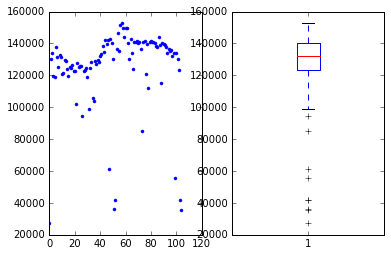

[27158 94735 61188 35945 41826 85320 55360 42041 35434]


In [7]:
# Plot Weekly Data
w=np.arange(0,105,1)

plt.figure(1)
plt.subplot(121)
plt.plot(w,weekly_data['#_of_parking'],'.b')

plt.subplot(122)
# 1. outlier
r=plt.boxplot(weekly_data['#_of_parking'])   
plt.show()

bottom_points = r["fliers"][0].get_data()[1]
print bottom_points

# Just 9 outliers seems Not enough 

{'boxes': [<matplotlib.lines.Line2D at 0x12664b090>],
 'caps': [<matplotlib.lines.Line2D at 0x12664bdd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x126666110>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x126659a90>],
 'whiskers': [<matplotlib.lines.Line2D at 0x12664b190>,
  <matplotlib.lines.Line2D at 0x12664b790>]}

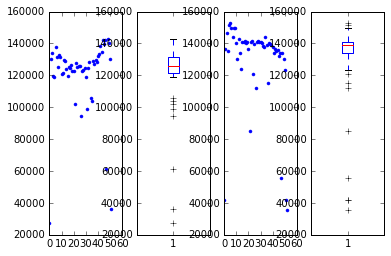

In [506]:
# 不同年的 outlier 程度不一样，不能全放在一起考虑

plt.figure(1)
plt.subplot(141)
plt.plot(np.arange(0,52,1),weekly_data.iloc[0:52,0],'.b')

plt.subplot(142)
plt.boxplot(weekly_data.iloc[0:52,0])

plt.subplot(143)
plt.plot(np.arange(0,53,1),weekly_data.iloc[52:105,0],'.b')

plt.subplot(144)
plt.boxplot(weekly_data.iloc[52:105,0])


In [ ]:
# outlier包含假期，但也有其它时间

holidays_lst = ['2014-01-01', '2015-01-01', '2016-01-01',
 '2014-05-26', '2015-05-25', '2016-05-30',
 '2014-07-04', '2015-07-03', '2015-07-04', '2016-07-04',
 '2014-09-01', '2015-09-07', '2015-09-05',
 '2014-11-27', '2014-11-28', '2015-11-26', '2015-11-27', '2016-11-24', '2016-11-25',
 '2014-12-25', '2015-12-25', '2015-12-25', '2015-12-26']

In [8]:
# Find Outliers Index

thresh=118000
weekly_data[weekly_data['#_of_parking']<thresh]['#_of_parking']
# 行标相邻，步长取多少为妙？

Year  Week#
2014  1         27158
      22       101839
      27        94735
      32        98816
      35       105615
      36       103613
      48        61188
      52        35945
2015  1         41826
      22        85320
      27       111976
      37       115230
      48        55360
      52        42041
      53        35434
Name: #_of_parking, dtype: int64

## 5. Outliers Smoothing

In [9]:
# Test data
data = { '#':np.arange(0,105,1) , 'count':weekly_data['#_of_parking'] }
df_test = pd.DataFrame(data)

In [10]:
# Moving average
step=5
for i in df_test[df_test['count']<thresh]['#']:
    if i<len(df_test)-step:
        df_test.iloc[i,1]=np.mean(df_test.iloc[(i+1):(i+step),1])
    else:
        df_test.iloc[i,1]=np.mean(df_test.iloc[(i-step):i,1])

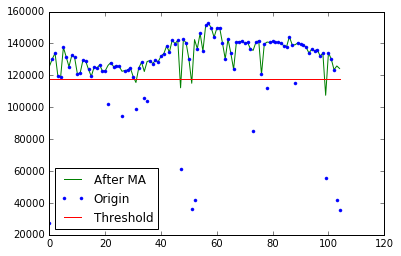

In [11]:
plt.plot(w,df_test['count'],'-g', label='After MA')
plt.plot(w,weekly_data['#_of_parking'],'.b', label='Origin')
y=[thresh]*len(w)
plt.plot(w,y,'-r', label='Threshold')
plt.legend(loc='best')

In [12]:
# Moving average--Once More
step=5
for i in df_test[df_test['count']<thresh]['#']:
    if i<len(df_test)-step:
        df_test.iloc[i,1]=np.mean(df_test.iloc[(i+1):(i+step),1])
    else:
        df_test.iloc[i,1]=np.mean(df_test.iloc[(i-step):i,1])

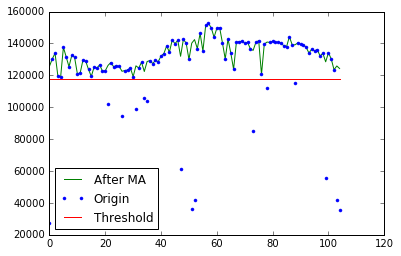

In [13]:
# df_test is final after moving average
plt.plot(w,df_test['count'],'-g', label='After MA')
plt.plot(w,weekly_data['#_of_parking'],'.b', label='Origin')
y=[thresh]*len(w)
plt.plot(w,y,'-r', label='Threshold')
plt.legend(loc='best')

In [540]:
df_test.head()

#      count
Year Week#              
2014 1      0  125712.25
     2      1  130244.00
     3      2  133918.00
     4      3  119845.00
     5      4  118842.00

## 6. Create Weekly Time Series Data 

In [14]:
data = { 'week_order': pd.date_range('1/1/2014', periods=105, freq='W') , '#_of_parking':df_test['count'] }
df_week = pd.DataFrame(data)
df_week.head()

#_of_parking week_order
Year Week#                         
2014 1         125712.25 2014-01-05
     2         130244.00 2014-01-12
     3         133918.00 2014-01-19
     4         119845.00 2014-01-26
     5         118842.00 2014-02-02

In [15]:
# Weekly fail－》succeed

# Sorted daily data
# df = data_train_new.sort(['Date'])
# df.head()
df_week_ts = df_week.set_index('week_order')
# df_ts.index
df_week_ts.index = pd.to_datetime(df_week_ts.index)
# df_ts.index
ts = df_week_ts['#_of_parking']  # 生成pd.Series对象
# 查看数据格式
print ts.head()
print ts.head().index   # 无序的
# 切片
# ts['2014-06']
# ts['2014-01-01':'2014-01-31']



week_order
2014-01-05    125712.25
2014-01-12    130244.00
2014-01-19    133918.00
2014-01-26    119845.00
2014-02-02    118842.00
Name: #_of_parking, dtype: float64
DatetimeIndex(['2014-01-05', '2014-01-12', '2014-01-19', '2014-01-26',
               '2014-02-02'],
              dtype='datetime64[ns]', name=u'week_order', freq=None)


# 平稳性检验
平稳性是进行时间序列分析的前提条件

## 7. Function for testing stationarity
- 根据选定的显著性水平（0.05或0.01），决定接受还是拒绝H0。如果P＞0.05，不能否定“差别由抽样误差引起”，则接受H0；如果P＜0.05或P ＜0.01，可以认为差别不由抽样误差引起，可以拒绝H0，则可以接受另一种可能性的假设（又称备选假设，符号为H1）
- 单位根检验：ADF是一种常用的单位根检验方法，他的原假设为序列具有单位根，即非平稳，对于一个平稳的时序数据，就需要在给定的置信水平上显著，拒绝原假设。检验结果，其p值大于0.99，说明并不能拒绝原假设。2014: p＝0.003772，可以拒绝原假设，所以序列稳定。2015: p=0.47, 不能拒绝原假设, 序列不稳定

In [22]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

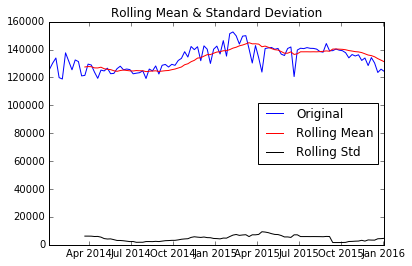

Results of Dickey-Fuller Test:
Test Statistic                  -1.574748
p-value                          0.496265
#Lags Used                       2.000000
Number of Observations Used    102.000000
Critical Value (5%)             -2.890321
Critical Value (1%)             -3.496149
Critical Value (10%)            -2.582122
dtype: float64


In [23]:
test_stationarity(ts)

## 8. Differential

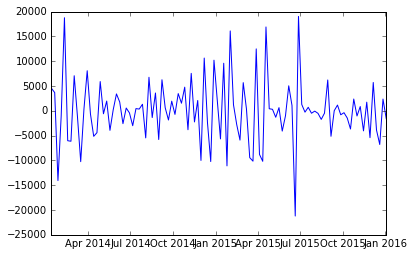

In [26]:
#Take first difference:
ts_diff = ts - ts.shift()
plt.plot(ts_diff)

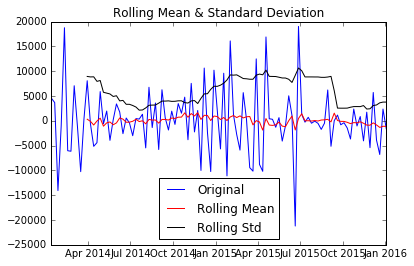

Results of Dickey-Fuller Test:
Test Statistic                -1.392383e+01
p-value                        5.236683e-26
#Lags Used                     1.000000e+00
Number of Observations Used    1.020000e+02
Critical Value (5%)           -2.890321e+00
Critical Value (1%)           -3.496149e+00
Critical Value (10%)          -2.582122e+00
dtype: float64


In [27]:
ts_diff.dropna(inplace=True)
test_stationarity(ts_diff)

## 9. Decide p&q

A nonseasonal ARIMA model is classified as an ARIMA(p,d,q) model, where:

p is the number of autoregressive terms,
d is the number of nonseasonal differences needed for stationarity, and
q is the number of lagged forecast errors in the prediction equation.

In [16]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

In [18]:
# https://bicorner.com/2015/11/16/time-series-analysis-using-ipython/
sm.stats.durbin_watson(ts)
# The value of Durbin-Watson statistic is close to 2 if the errors are uncorrelated. 
# In our example, it is 0.1395. That means that there is a strong evidence that 
# the variable open has high autocorrelation.

0.0022586983688288854

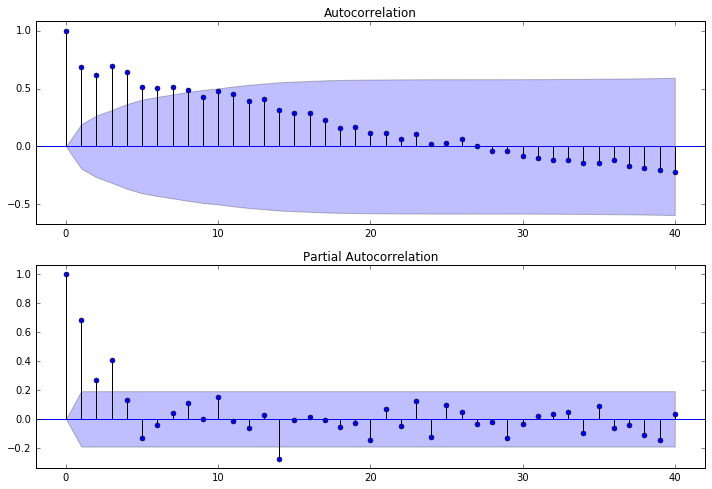

In [19]:
# show plots in the notebook
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts, lags=40, ax=ax2)

# Analysis: http://blog.csdn.net/aspirinvagrant/article/details/46323271
# ACF拖尾，PACF4后截尾，所以用AR（4）

In [20]:
# similar auto arima: http://stackoverflow.com/questions/22770352/auto-arima-equivalent-for-python

from statsmodels.tsa.arima_process import arma_generate_sample
import statsmodels.api as sm

res = sm.tsa.arma_order_select_ic(ts, ic=['aic', 'bic'], trend='nc')
res.aic_min_order
res.bic_min_order

# same with observed ACF,PACF

/Users/galphen/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 0)

## 10. Implement ARIMA 4，1，0

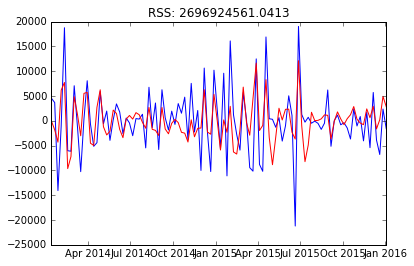

In [30]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts, order=(4, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_diff)**2))

Here we can see that the AR and MA models have almost the same RSS but combined is significantly better. Now, we are left with 1 last step, i.e. taking these values back to the original scale.

RSS越小越好

## 11. Recover Data to Original Scale

In [33]:
# store the predicted results as a separate series and observe it.
predictions_AR_diff = pd.Series(results_AR.fittedvalues, copy=True)
print predictions_AR_diff.head()

week_order
2014-01-12     -46.837871
2014-01-19   -1823.944919
2014-01-26   -4303.472745
2014-02-02    6176.575898
2014-02-09    7727.305172
dtype: float64


Notice that these start from ‘1949-02-01’ and not the first month. Why? This is because we took a lag by 1 and first element doesn’t have anything before it to subtract from. 

The way to convert the differencing to log scale is to add these differences consecutively to the base number. An easy way to do it is to first determine the cumulative sum at index and then add it to the base number. The cumulative sum can be found as:

In [34]:
predictions_AR_diff_cumsum = predictions_AR_diff.cumsum()
print predictions_AR_diff_cumsum.head()

week_order
2014-01-12     -46.837871
2014-01-19   -1870.782789
2014-01-26   -6174.255535
2014-02-02       2.320363
2014-02-09    7729.625535
dtype: float64


Next we’ve to add them to base number. For this lets create a series with all values as base number and add the differences to it. This can be done as:

In [35]:
predictions_AR = pd.Series(ts.ix[0], index=ts.index)
predictions_AR = predictions_AR.add(predictions_AR_diff_cumsum,fill_value=0)
predictions_AR.head()

week_order
2014-01-05    125712.250000
2014-01-12    125665.412129
2014-01-19    123841.467211
2014-01-26    119537.994465
2014-02-02    125714.570363
dtype: float64

Here the first element is base number itself and from thereon the values cumulatively added. Last step is to take the exponent and compare with the original series.
我这里没有求对数

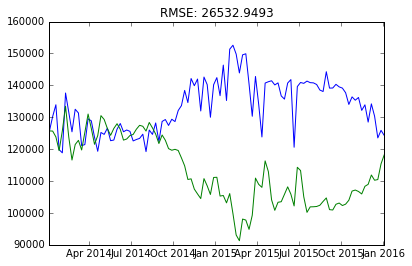

In [49]:
# predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_AR)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_AR-ts)**2)/len(ts)))
# plt.plot(2*124500-predictions_AR,'-r')

In [42]:
# def R2(y_test, y_true):
#     return 1 - ((y_test - y_true)**2).sum() / ((y_true - y_true.mean())**2).sum()